# Monte Carlo - Bootstrapping 

Name: Carlos Cocha

In [1]:
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

### 1. Read (or code directly) your 𝑥𝑖 ± 𝜎𝑥𝑖, 𝑦𝑖 ± 𝜎𝑦𝑖

In [2]:
# Reading the data from a .csv file
data = pd.read_csv("DATA.csv")
headers = ['x','y','sigma_x','sigma_y']
dframe = pd.DataFrame(data.values, columns = headers)
dframe

,x,y,sigma_x,sigma_y
0,0.50,2.40,0.02,0.6
1,0.90,3.10,0.09,1.8
2,1.50,4.70,0.15,1.5
3,1.80,4.90,0.18,0.6
4,2.65,6.30,0.45,3.0
5,3.00,8.05,0.05,0.2
6,3.45,8.80,0.07,0.4
7,4.10,11.50,0.25,3.2
8,4.65,11.20,0.15,0.8
9,5.25,14.30,0.25,2.4


In [3]:
# Copying the data into variables 
x = dframe['x']
y = dframe['y']
sx = dframe['sigma_x']
sy = dframe['sigma_y']

### 2. Obtain up to 𝑀 = 1000 sets of datapoints {{𝑥𝑖, 𝑦𝑖} k} 𝑖  = 1, …, 𝑁,  𝑘 = 1, …, 𝑀 by resampling from your experimental data. Use the generator producing random numbers with Gaussian distribution

In [4]:
M = 1000
resampling = [] # to save all the resampling data
for i in range(M):
    x_d , y_d = [] , []
    for j in range(len(x)):
        # random.randn produce random numbers with Gaussian distribution
        x_d.append(x[j] + sx[j]*np.random.randn())
        y_d.append(y[j] + sy[j]*np.random.randn())
    resampling.append([x_d, y_d])    

### 3. For each artificially resampled dataset, calculate their own slope and intercept (do NOT calculate their errors here!).

In [5]:
def slope_inter(x, y):
    '''
    Function to calculate the intercept (a) and the slope (b) parameters of
    y = a + b*x given the 2 sets of data (x, y)    .
    
    Parameter:
    x :: set of data x 
    y :: set of data y
    
    Example:
    slope_inter([0.5 , 0.9 , 1.5 , 1.8 , 2.65], [2.4 , 3.1 , 4.7 , 4.9 , 6.3])
    (1.5731 , 1.8414)
    '''
    x_m = np.mean(x)
    y_m = np.mean(y)
    numerator = 0
    denominator = 0
    for i in range(len(x)):
        numerator += (x[i]-x_m)*(y[i]-y_m)
        denominator += (x[i]-x_m)**2
    b = numerator/denominator
    a = y_m - b*x_m
    return a , b

In [6]:
a_b_dat = np.zeros((M, 2))
for i in range(M):
    # Calculate the slope and interception of each resampling dataset.
    a_b_dat[i][0], a_b_dat[i][1] = slope_inter(resampling[i][0], resampling[i][1]) 

### 4. Once the loop is finished, provide as output: 𝑎 ± 𝜎𝑎 and 𝑏 ± 𝜎𝑏 using the mean and standard deviation of the 𝑎𝑘,𝑏𝑘𝑘 = 1𝑀 values obtained.

In [7]:
def stand_d(x):
    '''
    Function to calculate the standard deviation of a set x.
    
    Parameters:
    x :: set of data
    
    Example:
    stand_d([2,5,2,4,5,7,3])
    - 1.82574
    '''
    x_m = np.mean(x)
    n = 0
    for i in range(len(x)):
        n += (x[i] - x_m)**2
    sd = np.sqrt(n/(len(x) - 1))
    return sd

In [8]:
a_m = a_b_dat[:, 0].mean()
b_m = a_b_dat[:, 1].mean()
sd_a = stand_d(a_b_dat[:, 0])
sd_b = stand_d(a_b_dat[:, 1])

In [9]:
print('The results using Bootstrapping method are:')
print('𝑎 ± 𝜎𝑎 = ' + str(round(a_m, 3)) +  " ± " + str(round(sd_a, 3)))
print('b ± 𝜎b = ' + str(round(b_m, 3)) +  " ± " + str(round(sd_b, 3)))

The results using Bootstrapping method are:
𝑎 ± 𝜎𝑎 = 0.883 ± 1.03
b ± 𝜎b = 2.393 ± 0.381


### 5. Plot your experimental datapoints ( including errorbars ) with the result of this linear regression.

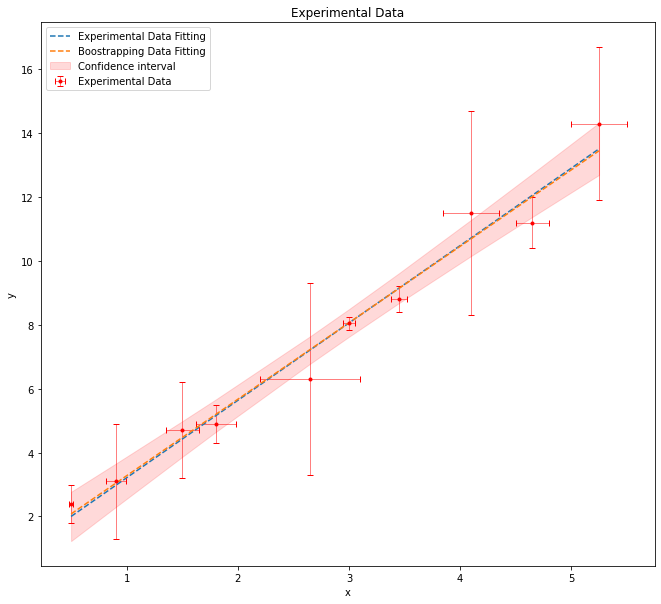

In [10]:
# Create a plot environment
fig, ax = plt.subplots(figsize = (11, 10))
# Experimental data fitting plot
a_d , b_d = slope_inter(x, y)
yfit = a_d + b_d*np.array(x)
plt.plot(x, yfit, "--", label = "Experimental Data Fitting")
plt.errorbar(x,y, xerr = sx, yerr = sy, fmt = 'ro', markersize = 3, 
             ecolor = 'red', capsize = 3,  linewidth = 0.5, 
             color = 'darkblue', label = "Experimental Data")
# Boostrapping data fitting plot
plt.plot(x, a_m + b_m*np.array(x), "--", label = "Boostrapping Data Fitting")
# Confidence interval plot
resid = y - yfit
s_err = np.sqrt(np.sum(resid**2)/(len(resid) - 1))    
t = stats.t.ppf(0.975, len(x)-1)
ci = t * s_err * np.sqrt(1/len(x) + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))    
plt.fill_between(x, yfit + ci, yfit - ci, color=[1, 0, 0, 0.15], label = "Confidence interval") 

plt.xlabel('x')
plt.ylabel('y')
plt.title('Experimental Data')
plt.legend()
plt.show()

### The covariance between the slope and intercept: cov(𝑎, 𝑏). This should NOT be zero (discuss why, if possible).

In [11]:
def cov(array1, array2):
    '''
    Function to calculate de covariance of 2 datasets.
    
    Parameters:
    array1 :: set of data1
    array2 :: set of data2
    
    Example:
    cov([1, 2, 4, 6, 3], [3, 5, 3, 2, 7])
    -1.5    
    '''
    n = 0
    M = len(array1)
    a1_m = np.array(array1).mean()
    a2_m = np.array(array2).mean()
    for i in range(M):
        n += (array1[i] - a1_m)*(array2[i] - a2_m)
    covariance = n/(M-1)
    return covariance

In [12]:
cov_a_b = cov(a_b_dat[:, 0], a_b_dat[:, 1])
print("The covariance between a and b is:", str(round(cov(a_b_dat[:, 0], a_b_dat[:, 1]),2)))

The covariance between a and b is: -0.34


By definition, covariance measures the total variation of two random variables from their expected values. A covariance equal to 0 means that the two variables are independent each other (no linear tendency), which is not our case. If we plot a vs. b we can notice some linear dependence:

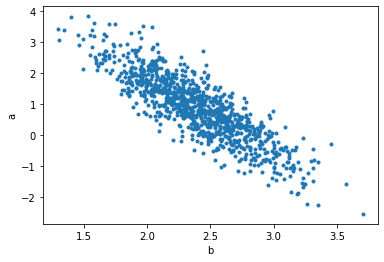

In [13]:
plt.plot(a_b_dat[:, 1], a_b_dat[:, 0], ".")
plt.xlabel('b')
plt.ylabel('a')
plt.show()

Which make sense because a and b are least-squares regression parameters (𝑎 = 𝑦 − 𝑏𝑥), that define the straight line that maximizes the amount of variation in y that can be explained by a linear regression on x. So, a and b are not independent of each other.

Also, using the covariance value allow us to estimate the direction of the relationship (whether the variables tend to move in tandem). According to the calculations the cov(a,b) < 0 which means that a and b coefficientes tend to move in the opposite directions (increase in a corresponds a decrease in b).

#### 2D frequency histogram (contour or heat map) of your fitting coefficients obtained for each resampling {𝑎𝑘,𝑏𝑘}𝑘=1, ..., 𝑀.

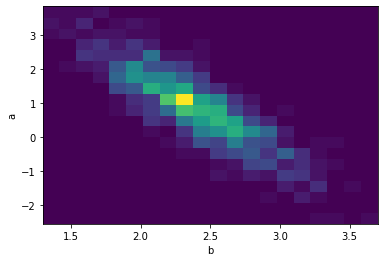

In [14]:
plt.hist2d(a_b_dat[:, 1], a_b_dat[:, 0], bins = 20)
plt.xlabel('b')
plt.ylabel('a')
plt.show()

### 1D frequency histograms of {𝑎𝑘}𝑘 = 1, ..., 𝑀 and {𝑏𝑘} 𝑘 = 1, ..., 𝑀.

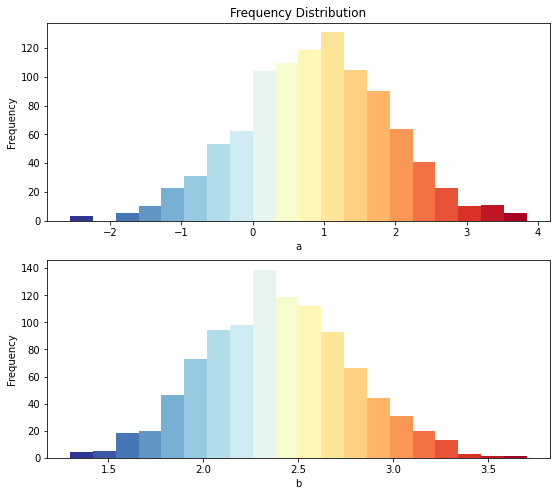

In [15]:
# Create a plot environment
fig = plt.figure(figsize=(9,8))
cm = plt.cm.get_cmap('RdYlBu_r')
gs = GridSpec(2,1)
# a frequency histogram
ax1 = fig.add_subplot(gs[0,0])
n, bins, patches = ax1.hist(a_b_dat[:, 0], bins = 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
ax1.set_title('Frequency Distribution')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('a')
    
# b frequency histogram
ax2 = fig.add_subplot(gs[1,0])
n, bins, patches = ax2.hist(a_b_dat[:, 1], bins = 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
ax2.set_ylabel('Frequency')
ax2.set_xlabel('b')
plt.show()   